In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.externals import joblib
import numpy as np
import seaborn as sns
sns.set_style('white')

rhino_root = '/'
df_fr3 = pd.read_csv('FR3_all_amp_2019-12-20.csv').iloc[:,1:]
df_fr5 = pd.read_csv('FR5_all_amp_2019-12-20.csv').iloc[:,1:]

In [57]:
df = pd.concat([df_fr3,df_fr5])  # combine two experiments
df['label'] = 'Encoding_LTC'
df['is_LTC'] = True

In [58]:
# list level analysis
grouped = df.groupby(['session', 'subject', 'label', 'experiment']) # group by session, subject, label, exp
# for name, group in grouped:
#     print(name)
#     print(np.mean(group['recalled']))

def p_summary(x):
    # return pd.DataFrame({'all':np.mean(x['recalled']), 'stim':np.mean(x['recalled'][x['is_stim_list']]), 'no_stim': np.mean(x['recalled'][~x['is_stim_list']])})
    return np.mean(x['recalled'])


df_all = grouped.apply(p_summary).reset_index(name = 'p_all') # recall rate for all items
df_stim = grouped.apply((lambda x: np.mean(x[x['is_stim_list'] == 1]['recalled']))).reset_index(name = 'p_stim')  # recall rate for stim list items
df_no_stim = grouped.apply((lambda x: np.mean(x[x['is_stim_list'] != 1]['recalled']))).reset_index(name = 'p_no_stim') # recall rate for non stim list items

In [69]:
df_temp = pd.merge(df_all, df_stim,  how = 'inner', on = ['session', 'experiment', 'subject', 'label'])
df_agg = pd.merge(df_temp, df_no_stim, how = 'inner', on = ['session', 'experiment', 'subject', 'label'])
df_agg['percent_change'] = (df_agg['p_stim'] - df_agg['p_no_stim'])/df_agg['p_all']*100  # calculate percent change
df_agg['type'] = 'List'
df_agg = df_agg.sort_values(['subject', 'session'])
df_agg.groupby('label')['percent_change'].apply(np.mean)
df_agg.groupby('label')['percent_change'].apply(len)
df_agg.groupby('label')['percent_change'].apply(lambda x: np.std(x)/np.sqrt(len(x)))

label
Encoding_LTC    14.953896
Name: percent_change, dtype: float64

In [70]:
df_agg = df_agg[df_agg['p_all'] > 0.10]
df_agg

,session,subject,label,experiment,p_all,p_stim,p_no_stim,percent_change,type
0,0,R1374T,Encoding_LTC,catFR5,0.193182,0.223958,0.111111,58.415033,List
7,2,R1374T,Encoding_LTC,catFR5,0.166667,0.177083,0.138889,22.916667,List
1,0,R1379E,Encoding_LTC,catFR5,0.242424,0.265625,0.180556,35.091146,List
2,0,R1465D,Encoding_LTC,catFR5,0.545455,0.546875,0.541667,0.954861,List
3,0,R1487T,Encoding_LTC,catFR5,0.075758,0.083333,0.055556,36.666667,List
6,1,R1487T,Encoding_LTC,catFR5,0.087121,0.072917,0.125000,-59.782609,List
4,0,R1488T,Encoding_LTC,catFR5,0.215909,0.223958,0.194444,13.669591,List
8,2,R1489E,Encoding_LTC,catFR5,0.458333,0.463542,0.444444,4.166667,List
9,3,R1489E,Encoding_LTC,catFR5,0.511364,0.536458,0.444444,17.993827,List
5,0,R1491T,Encoding_LTC,catFR5,0.018939,0.026042,0.000000,137.500000,List


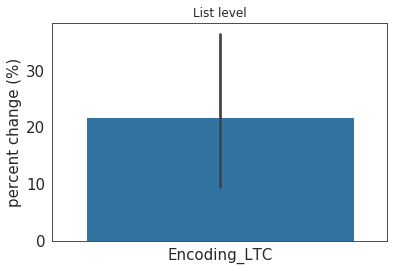

In [67]:
# plot percent change with 95% CI using bootstrap
fig, ax = plt.subplots(1)
ax = sns.barplot(df_agg['label'],df_agg['percent_change'], n_boot = 10000, orient = 'v')
ax.set_ylabel('percent change (%)', size = 15)
ax.set_xlabel('')
ax.set_title('List level')
ax.tick_params(labelsize = 15)

In [68]:
df_agg

,session,subject,label,experiment,p_all,p_stim,p_no_stim,percent_change,type
0,0,R1374T,Encoding_LTC,catFR5,0.193182,0.223958,0.111111,58.415033,List
7,2,R1374T,Encoding_LTC,catFR5,0.166667,0.177083,0.138889,22.916667,List
1,0,R1379E,Encoding_LTC,catFR5,0.242424,0.265625,0.180556,35.091146,List
2,0,R1465D,Encoding_LTC,catFR5,0.545455,0.546875,0.541667,0.954861,List
4,0,R1488T,Encoding_LTC,catFR5,0.215909,0.223958,0.194444,13.669591,List
8,2,R1489E,Encoding_LTC,catFR5,0.458333,0.463542,0.444444,4.166667,List
9,3,R1489E,Encoding_LTC,catFR5,0.511364,0.536458,0.444444,17.993827,List


In [73]:
# item level analysis
df_low = df[(df['classifier_output'] < 0.5)]
df_low = df
grouped = df_low.groupby(['subject', 'experiment','session', 'label'])

def p_summary(x):

    # return pd.DataFrame({'all':np.mean(x['recalled']), 'stim':np.mean(x['recalled'][x['is_stim_list']]), 'no_stim': np.mean(x['recalled'][~x['is_stim_list']])})
    return np.mean(x['recalled'])


df_all_low = grouped.apply(p_summary).reset_index(name = 'p_all')

#df_stim_low = grouped.apply((lambda x: np.mean(x[(x['is_stim_list'] == 1) & (x['classifier_output'] < 0.5)]['recalled']))).reset_index()
df_stim_low = grouped.apply((lambda x: np.mean(x[x['is_stim_item'] == 1])['recalled'])).reset_index(name =  'p_stim')
df_no_stim_low = grouped.apply((lambda x: np.mean(x[(x['is_stim_list'] != 1) & (x['classifier_output'] < 0.5)]['recalled']))).reset_index(name = 'p_no_stim') # look for items with classifier output < 0.5

df_temp_low = pd.merge(df_all_low, df_stim_low,  how = 'inner', on = ['session', 'experiment', 'subject', 'label'])
df_agg_low = pd.merge(df_temp_low, df_no_stim_low, how = 'inner', on = ['session', 'experiment', 'subject', 'label'])

df_agg_low = df_agg_low.sort_values(['session', 'subject'])
df_agg_low.reindex()

df_agg_low['percent_change'] = (df_agg_low['p_stim'].values - df_agg_low['p_no_stim'].values)/df_agg_low['p_all'].values
df_agg_low['type'] = 'Item'


df_agg_low.groupby('label')['percent_change'].apply(np.mean)
df_agg_low.groupby('label')['percent_change'].apply(len)
df_agg_low.groupby('label')['percent_change'].apply(lambda x: np.std(x)/np.sqrt(len(x)))


label
Encoding_LTC    0.210106
Name: percent_change, dtype: float64